# Global Water Watch - US
***

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import json
from shapely.geometry import box, mapping, shape
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pathlib import Path
from datetime import datetime
import time
from tqdm.auto import tqdm

from gwwapi import client
from gwwapi import utils

from lisfloodreservoirs import read_attributes, read_timeseries
from lisfloodreservoirs.utils.reservoir_curves import fit_reservoir_curve, storage_from_elevation, area_from_elevation

## GRanD

In [ ]:
path_grand = Path('/home/chus-casado/Datos/reservoirs/GRanD/v1_3')

grand = gpd.read_file(path_grand / 'GRanD_dams_v1_3.shp').set_index('GRAND_ID')

## ResOpsUS

In [ ]:
path_resops = Path('/home/chus-casado/Datos/reservoirs/ResOpsUS/v2.2')

# list of selected reservoirs
res_list = pd.read_csv(path_resops / 'selection' / 'reservoirs.txt', header=None).squeeze().tolist()

# load reservoir attributes
resops_attrs = read_attributes(
    path=path_resops / 'attributes',
    reservoirs=res_list,
    index_col='GRAND_ID'
)

# load time series
resops_ts = read_timeseries(
    path=path_resops / 'time_series' / 'csv',
    reservoirs=resops_attrs.index,
)
for grand_id, df in resops_ts.items():
    df.storage *= 1e-6
    df = df[df.columns.intersection(['inflow', 'outflow', 'storage', 'elevation'])]
    resops_ts[grand_id] = df

  0%|          | 0/164 [00:00<?, ?it/s]

### Reservoir curves

In [122]:
grand_id = 355

# attributes
dam_hgt_m, elev_masl, cap_mcm, area_skm = grand.loc[grand_id, ['DAM_HGT_M', 'ELEV_MASL', 'CAP_MCM', 'AREA_SKM']]

# observed time series
obs = resops_ts[grand_id].loc[datetime(2012, 1, 1):None].copy()

#### Polynomial

##### Brute force

In [123]:
a = area_skm / (2 * elev_masl)
b = 0
c = cap_mcm - area_skm * elev_masl / 2

In [136]:
curve1 = np.poly1d(np.array([a, b, c]))

In [137]:
curve1

poly1d([ 3.25582437e-02,  0.00000000e+00, -3.87892600e+04])

##### Fit

In [138]:
training = obs[['elevation', 'storage']].reset_index(drop=True)
training.sort_values(['elevation', 'storage'], ascending=True, inplace=True)
training = training[~(training['storage'].duplicated() | training['elevation'].duplicated())]
# mask = (df.storage.diff() < stor_thr) | (df.elevation.diff() < elev_thr)
# while mask.sum() > 0:
#     df = df[~mask]
#     mask = mask = (df.storage.diff() < stor_thr) | (df.elevation.diff() < elev_thr)
training.loc[len(training) + 1] = [elev_masl, cap_mcm]

In [139]:
# fit polynomial
curve2 = fit_reservoir_curve(training.elevation, training.storage, degree=2)

In [140]:
# estimated area
obs['area'] = curve.deriv()(obs.elevation)

In [144]:
z = np.linspace(0, elev_masl, num=100)

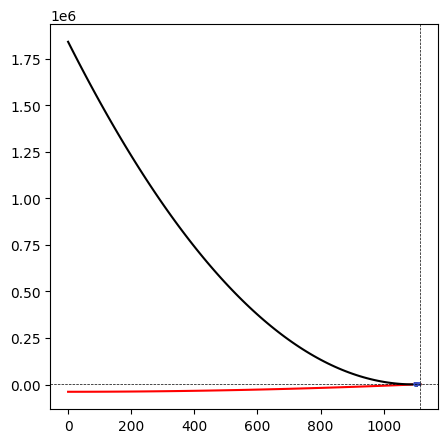

In [145]:
fig, ax = plt.subplots(figsize=(5, 5))
line_props = {'c': 'k', 'ls': '--', 'lw': .5}

ax.scatter(
    x=obs.elevation, 
    y=obs.storage,
    c=obs.index,
    cmap='coolwarm_r',
    s=2,
)
ax.plot(z, curve1(z), c='r', zorder=0)
ax.plot(z, curve2(z), c='k', zorder=0)
for x in [elev_masl]: #[elev_masl - dam_hgt_m, elev_masl]:
    ax.axvline(x, **line_props)
ax.axhline(cap_mcm, **line_props);

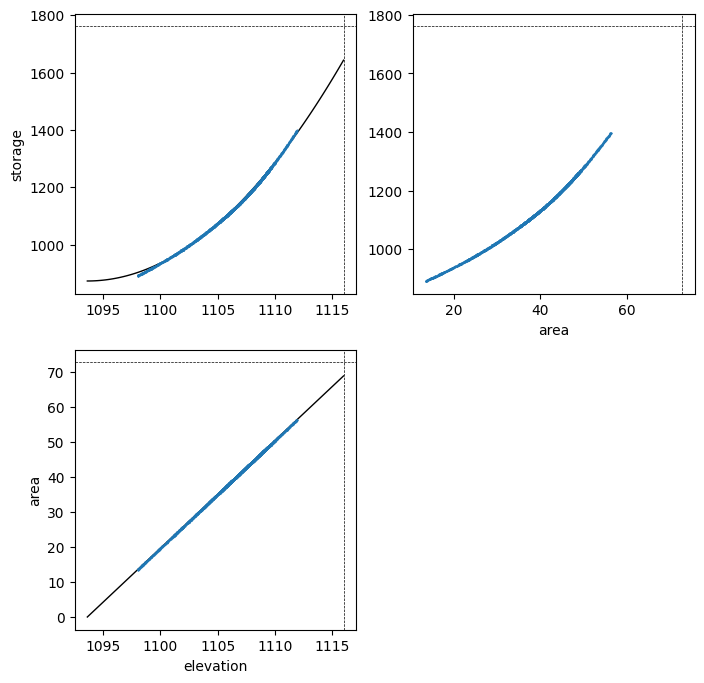

In [120]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))#, sharex=True, sharey=True)

variables = ['storage', 'area', 'elevation']
for r, vary in enumerate(variables[:-1]):
    for c, varx in enumerate(variables[::-1][:-1]):
        if r == 1 and c == 1:
            axes[r, c].axis('off')
            continue
        ax = axes[r, c]
        ax.scatter(
            obs[varx], 
            obs[vary], 
            marker='.', 
            s=1)
        if varx == 'elevation':
            ax.axvline(elev_masl, **line_props)
            if vary == 'storage':
                ax.plot(z, curve(z), c='k', lw=1, zorder=0)
            elif vary == 'area':
                ax.plot(z, curve.deriv()(z), c='k', lw=1, zorder=0)
        elif varx == 'area':
            ax.axvline(area_skm, **line_props)

        if vary == 'storage':
            ax.axhline(cap_mcm, **line_props)
        elif vary == 'area':
            ax.axhline(area_skm, **line_props)

        ax.set(
            xlabel=None if (r == 0) & (c == 0) else varx,
            ylabel=vary if c == 0 else None
        )

In [ ]:
# grand_id = 355

# fig, axes = plt.subplots(figsize=(16, 3))
# ax.scatter(
#     x=gww_ts[grand_id].index, 
#     y=gww_ts[grand_id].area_skm,
#     s=3,
# )
# ax.axhline(resops_attrs.loc[grand_id, 'AREA_SKM'], c='k', ls='--', lw=.5)
# ax.set(
#     ylim=(0, None),
#     ylabel='area (km2)'
# );

In [ ]:
grand_id = 355

In [ ]:
fig, ax = plt.subplots(nrows=2, figsize=(4, 8))

ax[0].scatter(
    x=df.elevation,
    y=df.storage,
    s=1,
    marker='.'
)
ax[0].plot(
    df.elevation,
    curve(df.elevation),
    c='k',
    lw=1,
    zorder=0
)

# ax[1].scatter(
#     x=df.elevation,
#     y=curve_za,
#     s=1,
#     marker='.'
# )
ax[1].plot(
    df.elevation,
    curve.deriv()(df.elevation),
    c='k',
    lw=1,
    zorder=0
)

In [ ]:
curve

In [ ]:
obs

#### Gradient

In [492]:
# compute bin averages
train_data = bin_data(obs.elevation, obs.storage, bin_size=.1)

# add maximum and minimum capacity
train_data.loc[elev_masl] = cap_mcm
train_data.loc[elev_masl - dam_hgt_m] = 0
train_data.sort_index(inplace=True)

In [520]:
# fit reservor curves by different methods
curves = {method: fit_reservoir_curve(train_data, method=method) for method in ['poly1d', 'interp1d', 'pchip']}

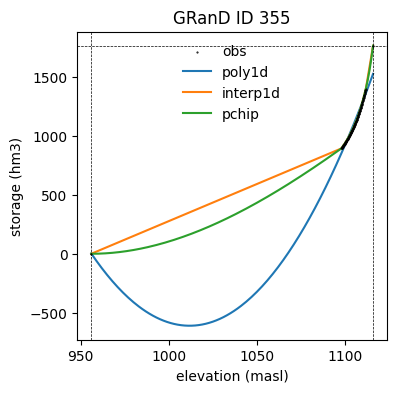

In [548]:
z = np.arange(elev_masl - dam_hgt_m, elev_masl +.5, 1)

fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(
    train_data.index,
    train_data.values,
    **point_props,
    c='k',
    label='obs', 
    zorder=10
);
for method, curve in curves.items():
    ax.plot(
        z,
        curve(z),
        label=method
    )

ax.axhline(cap_mcm, **line_props)
ax.axvline(elev_masl, **line_props)
ax.axvline(elev_masl - dam_hgt_m, **line_props)

ax.legend(frameon=False)
ax.set(
    xlabel='elevation (masl)',
    ylabel='storage (hm3)',
    title=f'GRanD ID {grand_id}'
);

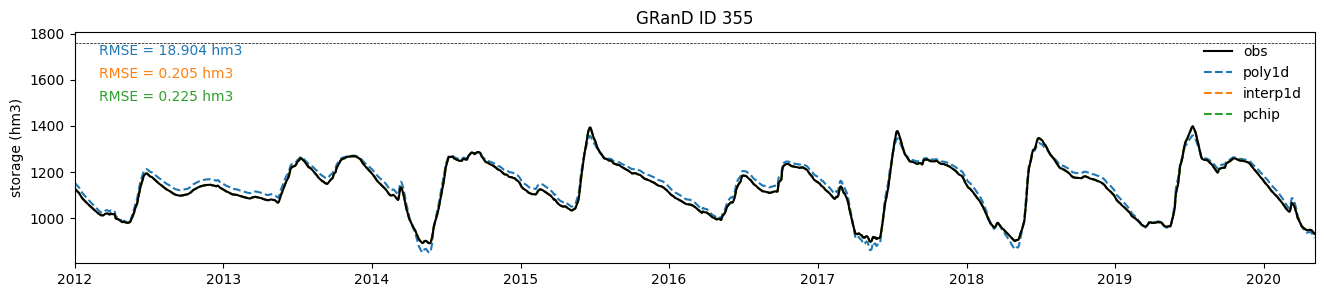

In [549]:
fig, ax = plt.subplots(figsize=(16, 3))

ax.plot(obs.storage, c='k', label='obs', zorder=10)

for i, (method, curve) in enumerate(curves.items()):
    storage = storage_from_elevation(curve, obs.elevation)
    ax.plot(storage, ls='--', label=method)
    rmse = np.sqrt(np.mean((obs.storage - storage)**2))
    ax.text(0.02, .95 - i * .1, f'RMSE = {rmse:.3f} hm3', c=f'C{i}', transform=ax.transAxes, va='top')

ax.axhline(cap_mcm, **line_props)

ax.legend(frameon=False)
ax.set(
    xlim=(obs.index.min(), obs.index.max()),
    ylabel='storage (hm3)',
    title=f'GRanD ID {grand_id}'
);

#### Elevation-area curve

In [606]:
df = pd.DataFrame(train_data.iloc[1:-1])

df['area'] = df.storage.diff() / df.index.to_series().diff()

In [607]:
# rolling mean to smooth the elevation-area curve
foo = df['area'].copy()
while foo.diff().min() <= 0:
    foo = foo.rolling(window=3, center=True).mean()
foo.dropna(inplace=True)

In [608]:
# df.loc[elev_masl - dam_hgt_m, 'area'] = 0
# df.loc[elev_masl, 'area'] = area_skm
# df.sort_index(inplace=True)

# mask = df.area.notnull()
# za_curve = PchipInterpolator(
#     df[mask].index, 
#     df[mask].area
# )

In [ ]:
foo2 = foo.copy()
foo2.loc[elev_masl - dam_hgt_m] = 0
foo2.loc[elev_masl] = area_skm
foo2.sort_index(inplace=True)

In [ ]:
za_curve = PchipInterpolator(
    foo2.index, 
    foo2.values
)

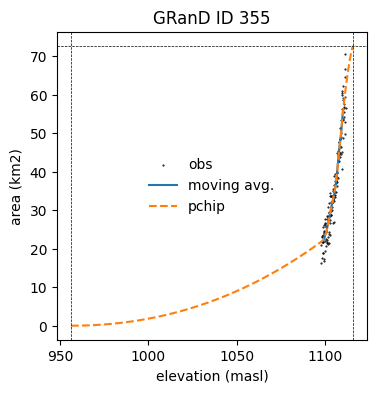

In [610]:
fig, ax = plt.subplots(figsize=(4, 4))

plt.scatter(
    df.index, 
    df.area,
    c='k', 
    label='obs',
    **point_props
)
plt.plot(foo, label='moving avg.')
plt.plot(z, za_curve(z), ls='--', label='pchip')
ax.axvline(elev_masl, **line_props)
ax.axvline(elev_masl - dam_hgt_m, **line_props)
ax.axhline(area_skm, **line_props)
ax.legend(frameon=False)
ax.set(
    xlabel='elevation (masl)',
    ylabel='area (km2)',
    title=f'GRanD ID {grand_id}'
);

In [613]:
curves['pchip'].derivative()

In [617]:
curves['poly1d'].deriv()

poly1d([ 3.92691363e-01, -3.97330675e+02])

In [615]:
curves['interp1d'].derivative()

AttributeError: 'interp1d' object has no attribute 'derivative'

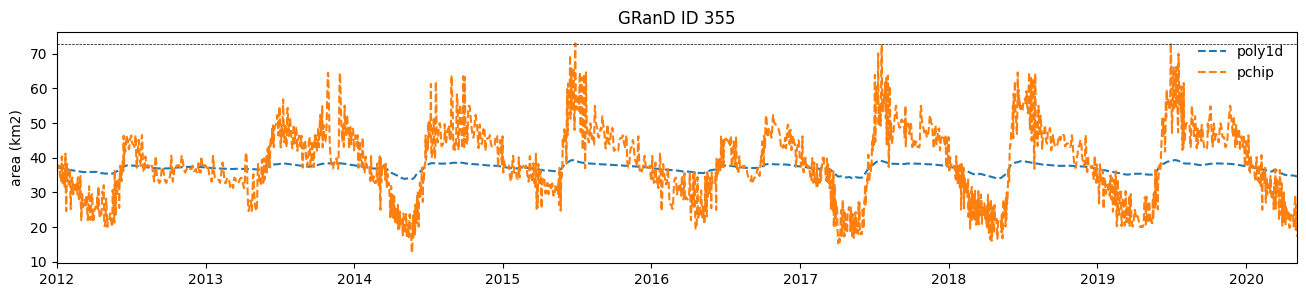

In [619]:
fig, ax = plt.subplots(figsize=(16, 3))

# ax.plot(obs.storage, c='k', label='obs', zorder=10)

for i, (method, curve) in enumerate(curves.items()):
    if method == 'poly1d':
        data = curve.deriv()(obs.elevation)
    elif method == 'pchip':
        data = curve.derivative()(obs.elevation)
    else:
        continue
    area = pd.Series(
        data=data,
        index=obs.index,
        name='area'
    )
    ax.plot(area, ls='--', label=method)
    # rmse = np.sqrt(np.mean((obs.storage - storage)**2))
    # ax.text(0.02, .95 - i * .1, f'RMSE = {rmse:.3f} hm3', c=f'C{i}', transform=ax.transAxes, va='top')

ax.axhline(area_skm, **line_props)

ax.legend(frameon=False)
ax.set(
    xlim=(obs.index.min(), obs.index.max()),
    ylabel='area (km2)',
    title=f'GRanD ID {grand_id}'
);

## Global Water Watch

In [ ]:
path_gww = Path('/home/chus-casado/Datos/reservoirs/GWW')

### Attributes

In [ ]:
def get_tiled_reservoirs(minx, miny, maxx, maxy, dx=10, dy=10):

    results = []
    xs = np.arange(minx, maxx, dx)
    ys = np.arange(miny, maxy, dy)

    for x0 in xs:
        for y0 in ys:
            x1 = min(x0 + dx, maxx)
            y1 = min(y0 + dy, maxy)
            tile_geom = box(x0, y0, x1, y1)
            tile_geojson = json.dumps(mapping(tile_geom))
            try:
                res = client.get_reservoirs_by_geom(tile_geojson)
                results.extend(res['features'])  # or adjust if structure is different
            except Exception as e:
                print(f"Failed for tile ({x0}, {y0}): {e}")
            time.sleep(0.5)  # optional: be kind to the server
    return results

In [ ]:
def features_to_gdf(features):
    """
    Convert a list of GeoJSON features to a GeoDataFrame.
    
    Args:
        features (list): List of GeoJSON features, each with 'geometry' and 'properties'
        
    Returns:
        gpd.GeoDataFrame
    """
    geometries = [shape(f['geometry']) for f in features]
    properties = [{**f['properties'], 'gww_id': f['id']} for f in features]
    gdf = gpd.GeoDataFrame(properties, geometry=geometries, crs="EPSG:4326").set_index('gww_id')
    return gdf

In [ ]:
# get reservoir features from GWW in the US
features = get_tiled_reservoirs(-127, 22, -64, 56)

In [ ]:
# convert to GeoPandas
gww_attrs = features_to_gdf(features)
gww_attrs.drop_duplicates(inplace=True)
print(f'{len(gww_attrs)} reservoirs in the US')

# find those with GRanD ID
gww_attrs.grand_id = gww_attrs.grand_id.astype('Int64')
in_grand = gww_attrs.grand_id.notnull()
print(f'{in_grand.sum()} reservoirs have a GRanD ID assigned')

In [ ]:
# export
path_gww_gis = path_gww / 'GIS'
path_gww_gis.mkdir(parents=True, exist_ok=True)
gww_attrs[in_grand].to_file(path_gww_gis / 'gww_US.shp')

### Time series

In [ ]:
gww_ts = {}
for grand_id in tqdm(resops_attrs.index):
    try:
        # get time series
        gww_id = gww_attrs[gww_attrs.grand_id == grand_id].index.item()
        ts = client.get_reservoir_ts(
            reservoir_id=gww_id,
            start=datetime(1975, 1, 1),
            stop=datetime(2025, 7, 1)
        )
        # adapt time stamp index
        ts = pd.DataFrame.from_dict(ts).set_index('t')
        ts.index = pd.to_datetime(ts.index, format='mixed', yearfirst=True)
        ts.index.name = 'Timestamp'
        # adapt data
        variables = ts.name.unique()
        if len(variables) == 1:
            ts.drop(['name', 'unit'], axis=1, inplace=True)
            ts.rename(columns={'value': 'area_skm'}, inplace=True)
            ts.area_skm *= 1e-6
        else:
            print(f'{gww_id} has more than 1 variable: {variables}')
            continue
        # save
        gww_ts[grand_id] = ts
    except:
        print(grand_id)

The reservoirs that failed are those with 2 or more features assigned in GWW.

## Embalse de la Serena (GRanD ID 2833)

In [ ]:
# retrieve information
geojson = client.get_reservoir_by_id(ID)
# Create the GeoDataFrame
geometry = shapely.geometry.shape(geojson['geometry'])
gdf = gpd.GeoDataFrame([geojson['properties']], geometry=[geometry], crs="EPSG:4326")

In [ ]:
gww_ts = client.get_reservoir_ts_monthly(
    reservoir_id=ID,
    start=datetime(1985, 1, 1),
    stop=datetime(2025, 7, 1)
)
gww_ts = pd.DataFrame.from_dict(gww_ts).set_index('t')
gww_ts.index = pd.to_datetime(gww_ts.index)
gww_ts.index.name = 'Timestamp'
gww_ts.drop(['name', 'unit'], axis=1, inplace=True)
gww_ts.rename(columns={'value': 'area_skm'}, inplace=True)
gww_ts.area_skm *= 1e-6

In [ ]:
# ts.name.value_counts()

In [ ]:
df = pd.concat([gww_ts.area_skm, resops_ts.storage.resample('MS').mean()], axis=1) * 1e-6
df.columns = ['area_skm', 'storage_mcm']
# df.dropna(axis=0, how='any', inplace=True)
df = df.loc[gww_ts.index[0]:gww_ts.index[-1]]

In [ ]:
# Define the GridSpec layout: 2 rows, 2 columns, with shared x-axis in second column
fig = plt.figure(figsize=(17, 8))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 4])

ax_map = fig.add_subplot(gs[0, 0])
gdf.plot(ax=ax_map)
ax_map.axis('off')

# Left column: area vs. volume
ax_curve = fig.add_subplot(gs[1, 0])  # span both rows
ax_curve.scatter(
    df.iloc[:,0], 
    df.iloc[:,1], 
    c=df.index,
    cmap='coolwarm',
    s=5,
    alpha=.5
)
ax_curve.set(
    xlabel='area (km2)',
    xlim=(0, None),
    ylabel='volume (hm3)',
    ylim=(0, None),
)

# Top-right: area time series
ax_area = fig.add_subplot(gs[0, 1])
ax_area.scatter(
    x=df.index,
    y=df.area_skm,
    c=df.index,
    cmap='coolwarm',
    s=5
)
ax_area.axhline(grand.loc[grand_id, 'AREA_SKM'], c='k', ls=':', lw=.5)
ax_area.text(gww_ts.index.max(), grand.loc[grand_id, 'AREA_SKM'], 'GRanD', ha='right', va='bottom')
ax_area.axhline(resops_attrs.loc[grand_id, 'AREA_MNL'], c='k', ls='--', lw=.5)
ax_area.text(gww_ts.index.max(), resops_attrs.loc[grand_id, 'AREA_MNL'], 'ResOpsES', ha='right', va='top')
ax_area.set(
    xlim=(gww_ts.index.min(), gww_ts.index.max()),
    ylim=(0, None),
    ylabel='area (km2)',
    title='GWW'
)

# Bottom-right: volume time series
ax_vol = fig.add_subplot(gs[1, 1], sharex=ax_area, sharey=ax_curve)
ax_vol.scatter(
    x=df.index,
    y=df.storage_mcm,
    c=df.index,
    cmap='coolwarm',
    s=5
)
ax_vol.axhline(grand.loc[grand_id, 'CAP_MCM'], c='k', ls=':', lw=.5)
ax_vol.axhline(resops_attrs.loc[grand_id, 'VOL_MNL'], c='k', ls='--', lw=.5)
ax_vol.set(
    xlim=(gww_ts.index.min(), gww_ts.index.max()),
    ylim=(0, None),
    ylabel='storage (hm3)',
    title='observed'
)

fig.suptitle(f"GRanD {grand_id} - {grand.loc[grand_id, 'DAM_NAME']}")
fig.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle


***

In [ ]:
area = pd.read_csv(f'./#{ID}/Surface Water Area (#{ID}).csv', parse_dates=True, index_col=0).squeeze()
area.index = [idx[:19] for idx in area.index]
area.index = pd.to_datetime(area.index, format='%Y-%m-%dT%H:%M:%S')
area.name = 'area_skm'

volume = pd.read_csv(f'./#{ID}/Surface Water Volume (#{ID}).csv', parse_dates=True, index_col=0).squeeze()
volume.index = [idx[:19] for idx in volume.index]
volume.index = pd.to_datetime(volume.index, format='%Y-%m-%dT%H:%M:%S')
volume *= 1e3
volume.name = 'volume_mcm'

gww_raw_ts = pd.concat([area, volume], axis=1)
gww_raw_ts.index.name = 'Timestamp'

gww_raw_ts.head()

In [ ]:
hydro_ts

In [ ]:
s = 3
xlim = (gww_raw_ts.index[0], gww_raw_ts.index[-1])

grand_area = grand.loc[grand_id, 'AREA_SKM']
grand_vol = grand.loc[grand_id, 'CAP_MCM']
snczi_area = resops_attrs.loc[grand_id, 'AREA_MNL']
snczi_vol = resops_attrs.loc[grand_id, 'VOL_MNL']

# fig, ax = plt.subplots(nrows=2, figsize=(16, 6), sharex=True)

fig = plt.figure(figsize=(18.5, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 5])

# ax00 = fig.add_subplot(gs[0, 0])
# # gdf.plot(ax=ax_map)
# # ax_map.axis('off')

# Left column: area vs. volume
ax10 = fig.add_subplot(gs[1, 0])  # span both rows
ax10.scatter(
    gww_raw_ts.area_skm, 
    gww_raw_ts.volume_mcm, 
    c=gww_raw_ts.index,
    cmap='coolwarm',
    s=5,
    alpha=.5
)
ax10.axvline(snczi_area, c='k', ls='--', lw=.5)
ax10.text(snczi_area, 0, 'ResOpsES', rotation=90, ha='right', va='bottom')
ax10.axhline(snczi_vol, c='k', ls='--', lw=.5)
ax10.text(0, snczi_vol, 'ResOpsES', ha='left', va='top')
ax10.set(
    xlabel='area (km2)',
    xlim=(0, None),
    ylabel='volume (hm3)',
    ylim=(0, None),
    title='GWW \n hypsometryc curve'
)

ax01 = fig.add_subplot(gs[0, 1])
ax01.plot(gww_ts, c='midnightblue', lw=1, label='GWW monthly', zorder=0)
ax01.scatter(
    x=gww_raw_ts.index,
    y=gww_raw_ts.area_skm,
    c=gww_raw_ts.index,
    cmap='coolwarm',
    s=s,
    label='GWW raw'
)
ax01.axhline(grand_area, c='k', ls=':', lw=.5)
ax01.text(xlim[0], grand_area, 'GRanD', ha='left', va='bottom')
ax01.axhline(snczi_area, c='k', ls='--', lw=.5)
ax01.text(xlim[0], snczi_area, 'ResOpsES', ha='left', va='top')
ax01.set(
    xlim=xlim,
    ylim=(0, None),
    ylabel='area (km2)'
)
ax01.legend(frameon=False)

ax11 = fig.add_subplot(gs[1, 1])
ax11.scatter(
    x=gww_raw_ts.index,
    y=gww_raw_ts.volume_mcm,
    c=gww_raw_ts.index,
    cmap='coolwarm',
    s=s,
    label='GWW'
)
ax11.plot(resops_ts.storage, c='k', lw=1, zorder=0, label='obs')
ax11.axhline(grand_vol, c='k', ls=':', lw=.5)
ax11.text(xlim[0], grand_vol, 'GRanD', ha='left', va='top')
ax11.axhline(snczi_vol, c='k', ls='--', lw=.5)
ax11.text(xlim[1], snczi_vol, 'ResOpsES', ha='right', va='top')
ax11.legend(frameon=False)
ax11.set(
    xlim=xlim,
    # ylim=(0, None),
    ylabel='volume (hm3)'
)

fig.suptitle(f"GRanD {grand_id} - {grand.loc[grand_id, 'DAM_NAME']}");